# Подготовка библиотек

In [32]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

fatal: destination path 'clothing-co-parsing' already exists and is not an empty directory.


In [33]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

import matplotlib.pyplot as plt
import os
from scipy import io
from sklearn.model_selection import train_test_split

# Проверить устройства для кераса

In [34]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1338616937196490142
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14444920832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16241508535628187197
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# Функции для визуализации

In [35]:
def display(display_list):
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# Загрузка датасета и обработка

In [36]:
DATASET_PATH = '/content/clothing-co-parsing/photos/'
MASKS_PATH = '/content/clothing-co-parsing/annotations/pixel-level/'

In [37]:
def preprocess_image(image):
     image = tf.cast(image, tf.float32)
     # scale values to [0,1]
     image = image/255.0
     # resize image
     image = tf.image.resize(image, (128,128))
     return image 
     

def preprocess_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    # будем использовать бинарную классификацию - фон и человек
    # для этого фон, закодированный нулем, оставим нулевым
    # все остальное будет равно единице
    mask = tf.cast(mask != 0, tf.uint8)
    return mask  

In [38]:
images = []
masks = []

for mask_filename in os.listdir(MASKS_PATH):
  image_filename = mask_filename[:-4] + '.jpg'
  image = img_to_array(load_img(DATASET_PATH + image_filename))
  images.append(preprocess_image(image))
      
  mask_file = io.loadmat(MASKS_PATH + mask_filename)
  mask = tf.convert_to_tensor(mask_file['groundtruth']) 
  masks.append(preprocess_mask(mask))

In [39]:
train_X, test_X, train_Y, test_Y = train_test_split(images, masks,\
                                                 test_size=0.2, random_state=0)
sample_image, sample_mask = train_X[0], train_Y[0]

train_X = tf.data.Dataset.from_tensor_slices(train_X)
test_X = tf.data.Dataset.from_tensor_slices(test_X)
train_Y = tf.data.Dataset.from_tensor_slices(train_Y)
test_Y = tf.data.Dataset.from_tensor_slices(test_Y)

train = tf.data.Dataset.zip((train_X, train_Y))
test = tf.data.Dataset.zip((test_X, test_Y)) 

In [40]:
# функции для аугментации 

# яркость
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# оттенок
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

# отзеркаливание по горизонтали
def flip_horisontal(img, mask):
     img = tf.image.flip_left_right(img)
     mask = tf.image.flip_left_right(mask)
     return img, mask

# отзеркаливание по горизонтали
def flip_horisontal(img, mask):
     img = tf.image.flip_left_right(img)
     mask = tf.image.flip_left_right(mask)
     return img, mask     


# отзеркаливание по горизонтали
def flip_verticl(img, mask):
     img = tf.image.flip_up_down(img)
     mask = tf.image.flip_up_down(mask)
     return img, mask       

In [41]:
# последовательно применяем аугментации
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(flip_horisontal))
train = train.concatenate(train.map(flip_verticl))

In [42]:
len(train)

12848

In [43]:
BATCH_SIZE = 32
BUFFER_SIZE = 500
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train = train.prefetch(buffer_size=BUFFER_SIZE)
test = test.batch(BATCH_SIZE) 

далее обучайте на датасете train, для валидации используйте датасет test аналогично как на занятии

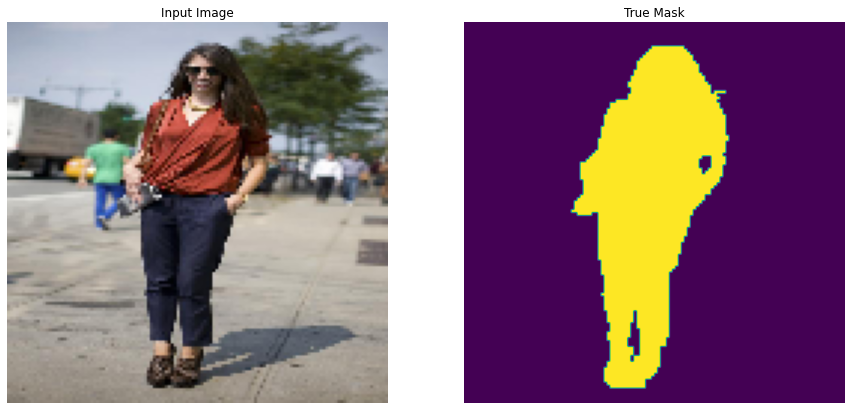

In [44]:
display([sample_image, sample_mask])

In [45]:
tf.unique(tf.reshape(sample_mask, -1))

Unique(y=<tf.Tensor: shape=(2,), dtype=uint8, numpy=array([0, 1], dtype=uint8)>, idx=<tf.Tensor: shape=(16384,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)

# Модель

In [46]:
tf.random.set_seed(0)

In [47]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [48]:
up_stack = [
    tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu')
]

In [49]:
def resolution_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, 
                                         padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [50]:
OUTPUT_CHANNELS = 2

model = resolution_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

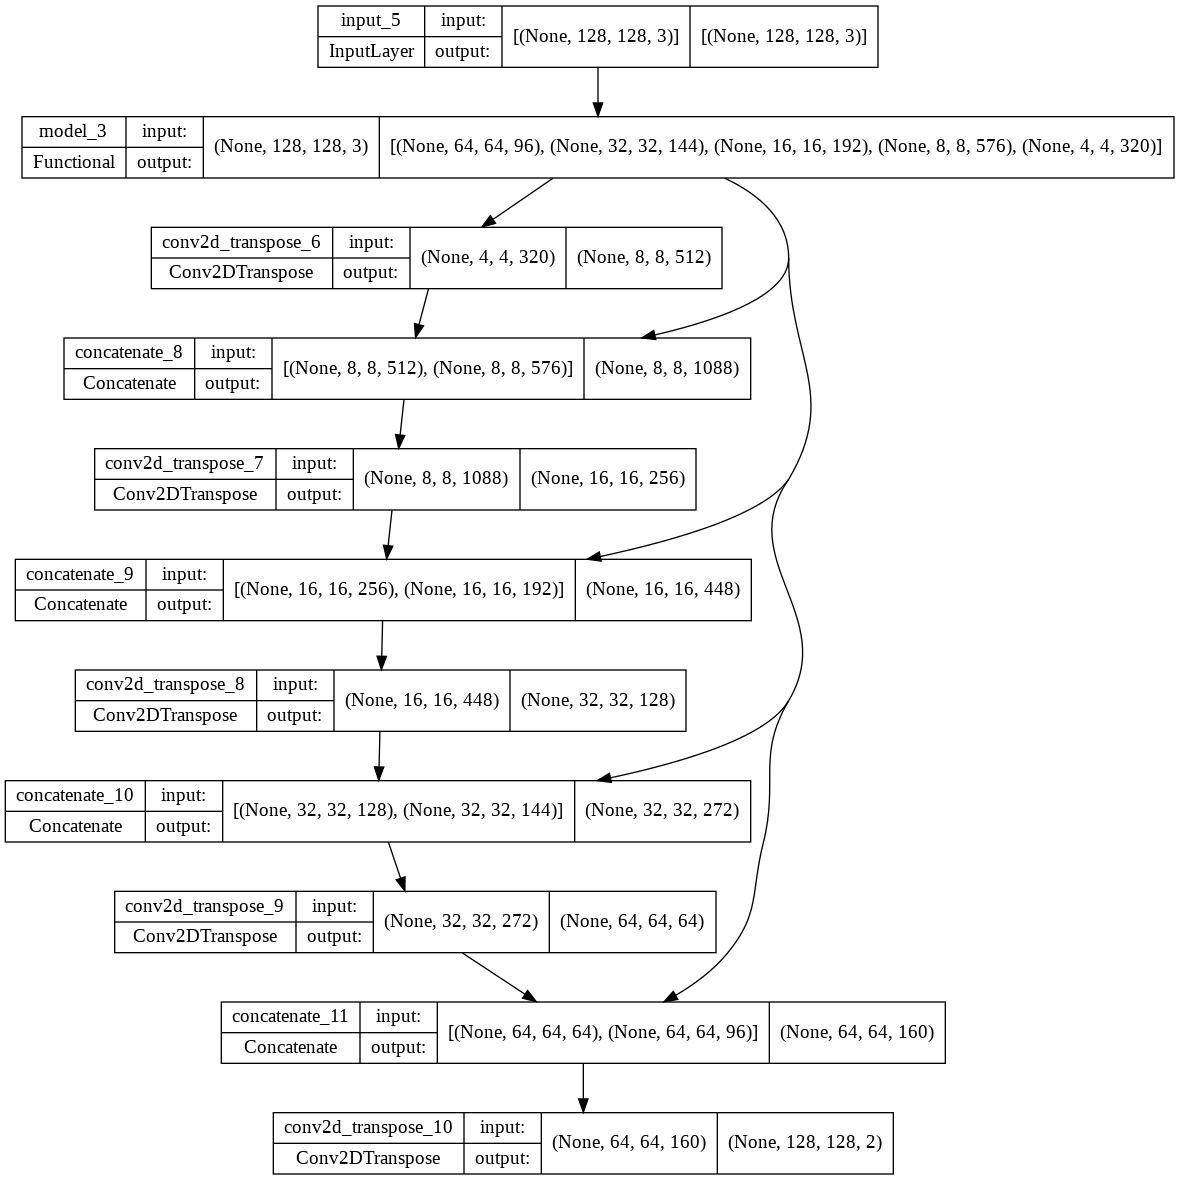

In [51]:
tf.keras.utils.plot_model(model, show_shapes=True)

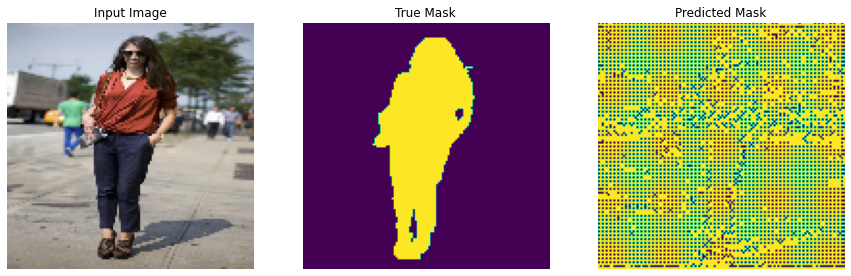

In [52]:
show_predictions(model)

# Обучение

In [53]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(BUFFER_SIZE)
test_dataset = test.batch(BATCH_SIZE)

In [54]:
# Добавим колбаек с уменьшением learning_rate по мере увеличения эпох

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions(model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

    
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

Epoch 1/10
402/402 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9520

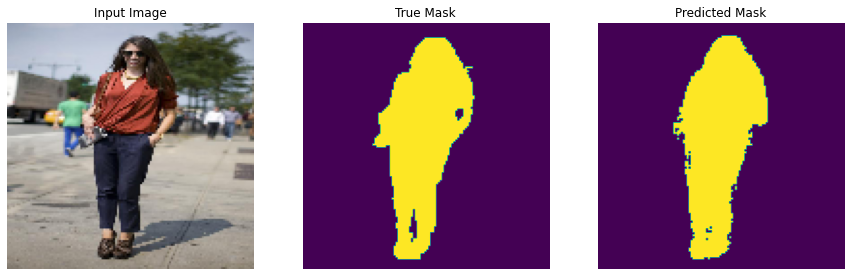


Sample Prediction after epoch 1

402/402 [==============================] - 31s 71ms/step - loss: 0.1166 - accuracy: 0.9520 - val_loss: 0.1027 - val_accuracy: 0.9603 - lr: 0.0010
Epoch 2/10
401/402 [============================>.] - ETA: 0s - loss: 0.0603 - accuracy: 0.9765

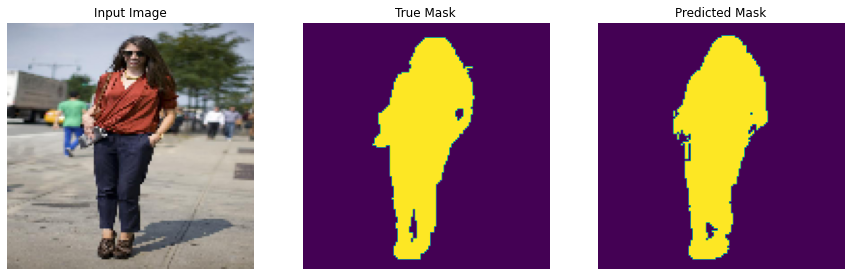


Sample Prediction after epoch 2

402/402 [==============================] - 26s 65ms/step - loss: 0.0603 - accuracy: 0.9765 - val_loss: 0.0815 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 3/10
401/402 [============================>.] - ETA: 0s - loss: 0.0463 - accuracy: 0.9819

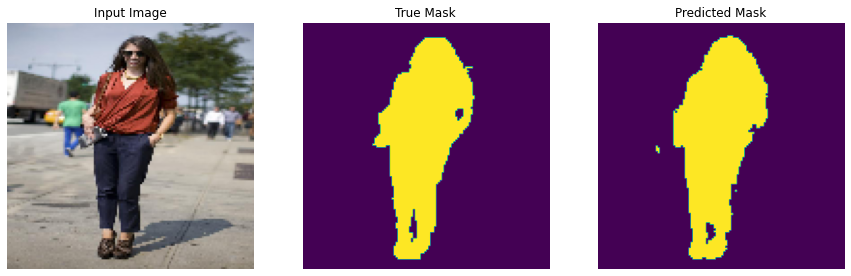


Sample Prediction after epoch 3

402/402 [==============================] - 26s 65ms/step - loss: 0.0463 - accuracy: 0.9819 - val_loss: 0.0799 - val_accuracy: 0.9715 - lr: 0.0010
Epoch 4/10
401/402 [============================>.] - ETA: 0s - loss: 0.0380 - accuracy: 0.9850

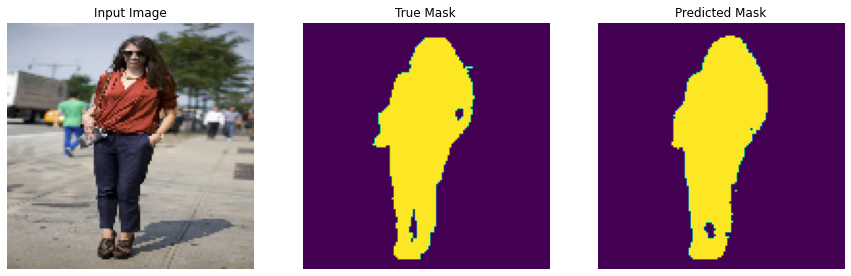


Sample Prediction after epoch 4

402/402 [==============================] - 26s 66ms/step - loss: 0.0380 - accuracy: 0.9850 - val_loss: 0.0850 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 5/10
401/402 [============================>.] - ETA: 0s - loss: 0.0320 - accuracy: 0.9873

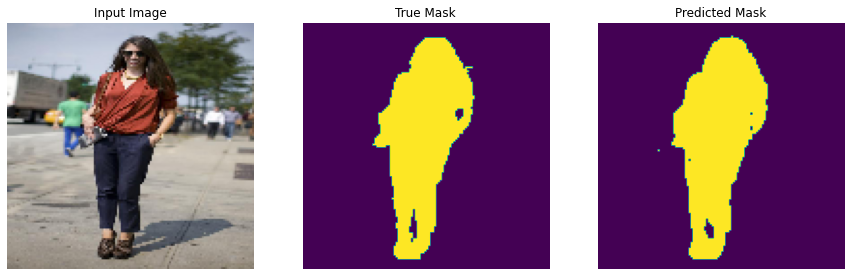


Sample Prediction after epoch 5

402/402 [==============================] - 27s 66ms/step - loss: 0.0320 - accuracy: 0.9873 - val_loss: 0.0897 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 6/10
401/402 [============================>.] - ETA: 0s - loss: 0.0279 - accuracy: 0.9889

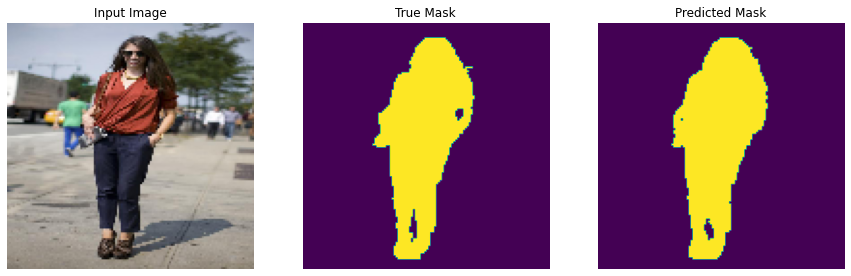


Sample Prediction after epoch 6

402/402 [==============================] - 27s 66ms/step - loss: 0.0279 - accuracy: 0.9889 - val_loss: 0.0934 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 7/10
401/402 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9901

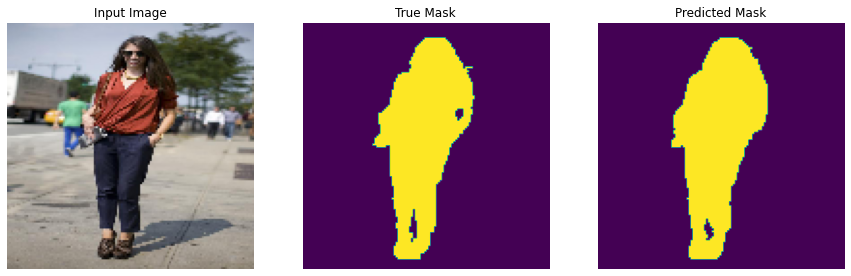


Sample Prediction after epoch 7

402/402 [==============================] - 27s 68ms/step - loss: 0.0248 - accuracy: 0.9901 - val_loss: 0.1014 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 8/10
401/402 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9909

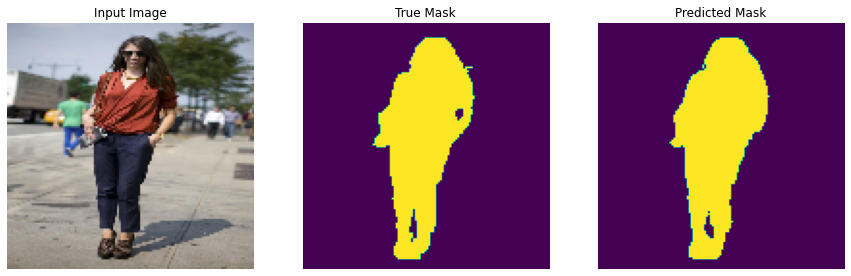


Sample Prediction after epoch 8

402/402 [==============================] - 27s 67ms/step - loss: 0.0227 - accuracy: 0.9909 - val_loss: 0.1031 - val_accuracy: 0.9717 - lr: 0.0010
Epoch 9/10
402/402 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9918

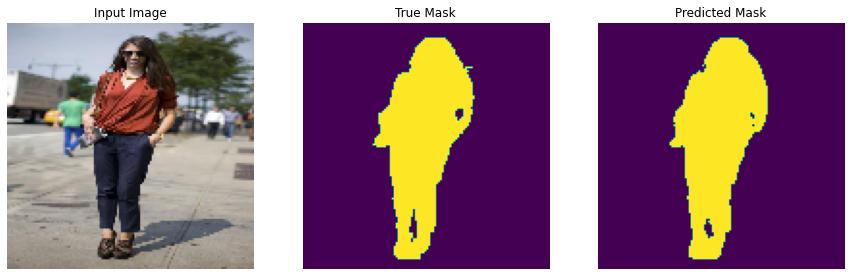


Sample Prediction after epoch 9

402/402 [==============================] - 27s 67ms/step - loss: 0.0204 - accuracy: 0.9918 - val_loss: 0.1090 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 10/10
401/402 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9924

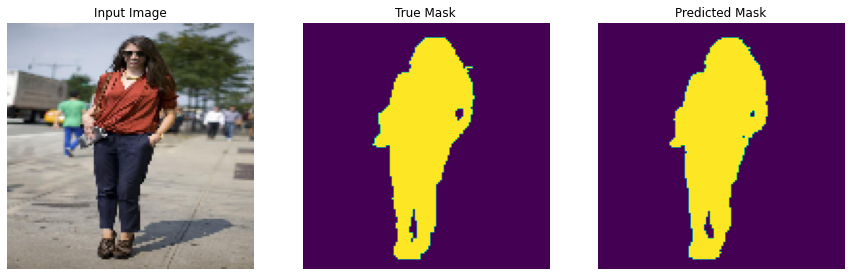


Sample Prediction after epoch 10

402/402 [==============================] - 28s 70ms/step - loss: 0.0190 - accuracy: 0.9924 - val_loss: 0.1086 - val_accuracy: 0.9719 - lr: 0.0010


In [55]:
OUTPUT_CHANNELS = 2
tf.random.set_seed(29)
EPOCHS = 10



model = resolution_model(OUTPUT_CHANNELS)


model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train, epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test,
                    callbacks=[callback_lr, DisplayCallback()])

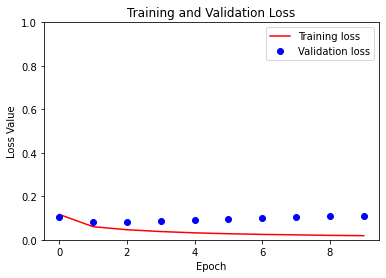

In [56]:
epochs = range(EPOCHS)

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()



К ДЗ:


Обучена нейросеть на датасете clothing-co-parsing с использованием кода с лекции. Добавлен вараинт с аугментацией и callback.

